In [1]:
#!compile_models.py (Uncomment this line to compile BiCEP models)
import BiCEP_functions as BiCEP
from sklearn.decomposition import PCA
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
font={'size':18}
rc('font',**font)

-W- cartopy is not installed
    If you want to make maps, install using conda:
    conda install cartopy
-W- You haven't installed a module for plotting maps (cartopy or Basemap)
    Recommended: install cartopy.  With conda:
    conda install cartopy
    For more information, see http://earthref.org/PmagPy/Cookbook#getting_python


### BiCEP Figures

This notebook produces figures that require BiCEP (Figures 4 and 5 in the paper). BiCEP can be obtained from https://github.com/bcych/BiCEP_GUI

In [2]:
#Uncomment the line below to generate the data table for BiCEP. It should already be generated currently.
#BiCEP.generate_arai_plot_table('arai_data')

In [3]:
def get_frac(specimen):
    """
    Calculates the NRM Fraction from VDS (Shaar and Tauxe, 2013)
    
    Inputs
    ------
    specimen: BiCEP specimen object
    specimen to obtain FRAC from
    
    Returns
    -------
    FRAC: float
    calculated FRAC
    """
    #Calculate VDS of all steps
    totalsum=np.linalg.norm(np.sum(np.diff(specimen.IZZI.loc[:,'NRM_x':'NRM_z'].values,axis=0),axis=0))+np.linalg.norm(specimen.IZZI.loc[:,'NRM_x':'NRM_z'].values[-1])
    
    #Calculate VDS of just our steps
    truncsum=np.linalg.norm(np.sum(np.diff(specimen.IZZI_trunc.loc[:,'NRM_x':'NRM_z'].values,axis=0),axis=0))
    
    if all(specimen.IZZI_trunc.iloc[-1,:-3]==specimen.IZZI.iloc[-1,:-3]):
        truncsum+=np.linalg.norm(specimen.IZZI.loc[:,'NRM_x':'NRM_z'].values[-1])
        
    #Calculate FRAC based on sum of points
    FRAC=truncsum/totalsum
    return(FRAC)

def get_interps(site,mad,dang,drat):
    """
    Auto-Interpreter for BiCEP. Calculates MAD_coe, DANG and DRAT
    for every possible interpretation with 4 or more points on 
    the Arai plot. Selects the interpretation that passes the 
    criteria which has the highest FRAC.
    
    Inputs
    ------
    site: BiCEP specimenCollection object
    Site/sample to calculate interpretations for
    
    mad: float
    MAD_Coe criterion threshold
    
    dang: float
    DANG criterion threshold
    
    DRAT: float
    DRAT criterion threshold
    
    Returns
    -------
    None
    """
    # Loop through specimens
    for specimen in site.specimens.values():
        #Make lists of lower, upper and fracs
        interps_lower=[]
        interps_upper=[]
        fracs=[]
        lowerTemps=specimen.temps[:-4]
        
        #Loop through interpretation
        for i in range(len(lowerTemps)):
            lowerTemp=lowerTemps[i] #Get lower temperature bound
            for upperTemp in specimen.temps[i+3:]: #Get upper temperature bound
                
                #Change specimen temperatures
                specimen.change_temps(lowerTemp,upperTemp)
                
                #Calculate MAD_coe
                pca=PCA(n_components=3)
                mad_est=BiCEP.get_mad(specimen.ZI,pca)
                
                #Check whether intepretation fits criteria
                if (mad_est<mad)&(specimen.dang<dang)&(specimen.drat<drat):
                    fracs.append(get_frac(specimen))
                    interps_lower.append(lowerTemp)
                    interps_upper.append(upperTemp)
                    
        #Make into arrays
        interps_lower=np.array(interps_lower)
        interps_upper=np.array(interps_upper)
        fracs=np.array(fracs)
        
        
        #If nothing passes, (specimens labeled aa were bad in one dataset)
        #Exclude from analysis
        if len(fracs)==0 or 'aa' in specimen.name:
            specimen.active=False #Exclude
            
            #Set temperature range to 0,0
            lowerTemp=specimen.temps[0]
            upperTemp=specimen.temps[0]
    
        #If some things pass, set lower and upper temps to what maximizes FRAC
        if len(fracs)>0:
            #Add specimen to analysis if previously excluded.
            specimen.active=True
            #Passing interpretation that maximizes FRAC
            lowerTemp=interps_lower[fracs==max(fracs)][0]
            upperTemp=interps_upper[fracs==max(fracs)][0]

        #Save changes to specimens
        specimen.change_temps(lowerTemp,upperTemp)
        specimen.save_changes()

In [2]:
data=BiCEP.ThellierData('arai_data.csv')

### Auto Interpreting With BiCEP
In this paper, we accept sites where the full width ($B_{max}-B_{min}$) is less than 10 $\mu T$ or 40\% of the median value. We only use specimens for which DANG and DRAT are <10 and MAD$_{\text{Coe}}$<5. For more information see Paterson et al (2014) and for information on MAD$_{\text{Coe}}$, please refer to the paper cited in the readme.

The following functions show how one can auto interpret data using BiCEP. You do not need to rerun these analyses to plot the figures as the BiCEP fits are saved in `.nc` files in this folder, and the interpretation temperatures are saved to a `.redo` file.

In [5]:
def get_sampler_success(site):
    """
    Checks for a BiCEP site result has a full width of its credible
    interval <16 μT or 40% of the median. Additionally, checks that
    the sampler did not fail the rhat criterion (if it does, you may
    need to rerun this function on the site). The function also 
    outputs a warning if the skewness of the distribution of the 
    site mean intensity is highly skewed, which can be indicative of
    a result which cannot exclude zero. These results have a higher
    chance of being inaccurate because the mean is restricted to be
    greater than zero and so this may artificially reduce the 
    uncertainty in the mean value.
    
    Inputs
    ------
    site: BiCEP specimenCollection object
    site/sample used to check for success.
    
    Returns
    -------
    True/False: bool
    Whether the site has a successful result or not.
    """
    
    #Get the Rhats for BiCEP
    rhat_worst=site.get_specimen_rhats()
    
    #Get the distribution of possible site mean intensities
    int_site=BiCEP.extract_values(site.fit,'int_site')
    
    #Get the percentiles of the intensity
    minB,medB,maxB=np.percentile(int_site,(2.5,50,97.5))
    
    #Look at the percentile criteria
    percentcrit=(maxB-minB)/medB
    absolutecrit=maxB-minB
    
    
    #Get skewness of the distribution
    skew=stats.skew(int_site)
    
    #Warn if high skewness (not a gaussian distribution)
    if (percentcrit>=0.4)&(absolutecrit<16)&(skew>1):
        print("Warning"+site.name+"has a distribution which cannot rule out zero field strength, this may cause a passing grade even when it shouldn't")
    #If it's a good sample (0.9<rhat<1.1) and passes our criteria for precision, it passes
    elif (rhat_worst<1.1)&(rhat_worst>0.9)&((percentcrit<0.4)|(absolutecrit<16)):
        print(site.name+' successful! Estimated intensity %2.1f'%medB+' with bounds of %2.1f'%minB+' - %2.1f'%maxB+' μT')
        return True
    #Otherwise, it fails
    else:
        return False


def run_site_fit(site):
    """
    Runs a BiCEP fit to a site, automatically choosing
    specimen level interpretations.
    
    Inputs
    ------
    site: BiCEP specimenCollection object.
    site/specimen to run fit on
    
    Returns
    -------
    None
    """
    
    #Check if 4 or more specimens. BiCEP almost always fails with less.
    if len(site.specimens)>=4:
        get_interps(site,5,10,10) #Get interpretations
        
    #Skip site otherwise
    else:
        print('skipping site '+site.name+', not enough specimens passed criteria')
        return
    
    actives=0
    #Check how many specimens had a passing interpretation

    for specimen in site.specimens.values():
        if specimen.active==True:
            actives+=1
    
    #If more than 4 had a passing interpretation, run BiCEP
    if actives>=4:
        #We use 10000 n_samples and the fast model here. If you're having issues
        #Run with higher n_samples and/or the "slow" model
        site.BiCEP_fit(model=BiCEP.model_circle_fast,n_samples=10000)
        success=get_sampler_success(site) #Check we passed
        
        if success==True: #If succesful, save the BiCEP fit
            site.fit.to_netcdf(site.name+'.nc')
            
        else: #Otherwise say it failed
            print(site.name+' did not have a passing estimate with BiCEP')
            
    #If less than 4 specimens pass minimal criteria, ignore site.
    else:
        print('skipping site '+site.name+', not enough specimens passed criteria')
        return

In [6]:
#This cell runs through every site and performs BiCEP
#If you want to rerun the analysis or try this on your own data, run this and grab a coffee
#for site in data.collections:
    #run_site_fit(data['site'])

In [7]:
#This cell saves your BiCEP fits to the MagIC tables
#for site in data.collections:
    #try:
        #success=get_sampler_success(data[site])
    #except:
        #success=False
    #if success:
        #data[site].save_magic_tables()

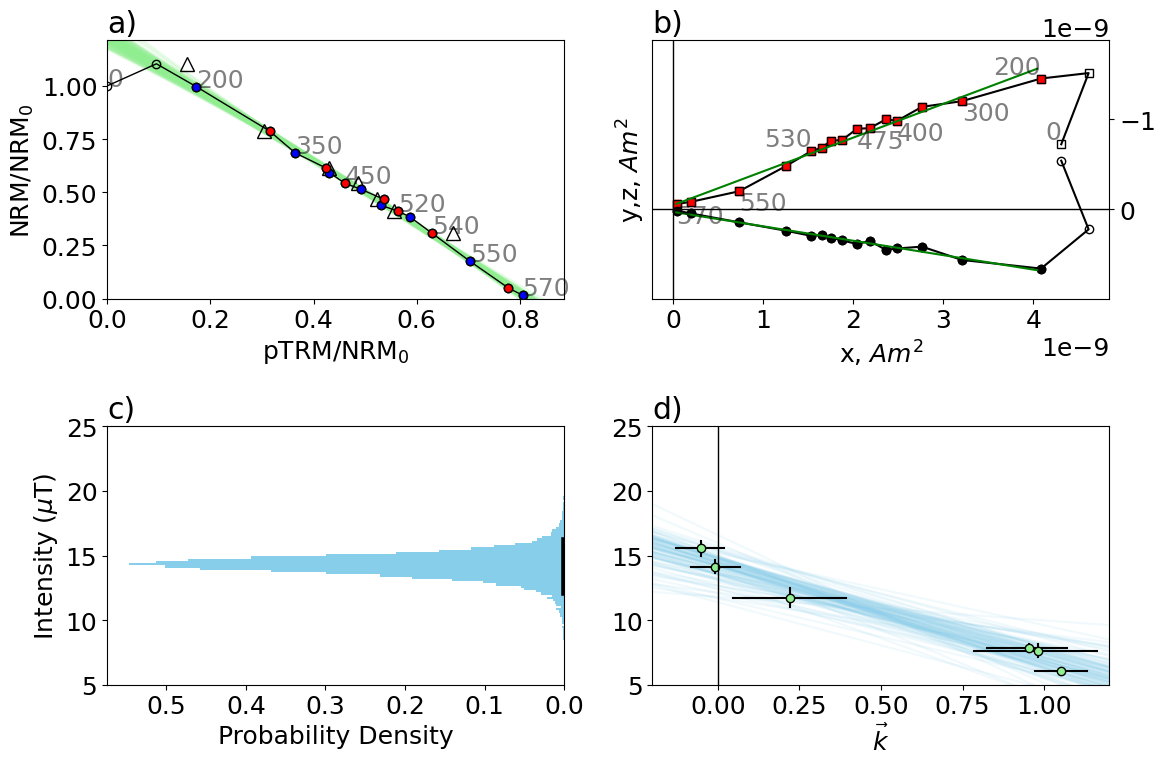

In [8]:
### This plots figure 3 from the paper

#Specify what site and specimen we're using as objects
site=data['MU111']
specimen=site['MU111A05']

#Set up specimen
fig,ax=plt.subplots(2,2,figsize=(12,8))

#Plot the Arai plot
specimen.plot_arai(ax[0,0])
specimen.plot_circ(ax[0,0]) #Green BiCEP fits

#Plot the Zijderveld plot
specimen.plot_zijd(ax[0,1])

#Plot the BiCEP site level line fits
site.regplot(ax[1,1])
minB,maxB=np.percentile(BiCEP.extract_values(site.fit,'int_site'),(2.5,97.5))

#Plot histogram and bounds
ax[1,0].hist(BiCEP.extract_values(site.fit,'int_site'),bins=100,color='skyblue',orientation='horizontal',density=True)
ax[1,0].plot([0,0],[minB,maxB],'k',linewidth=4)

#Set up axis labels and limits
ax[1,0].set_xlim(np.flip(ax[1,0].get_xlim()))
ax[1,1].set_xlim(-0.2,1.2)
ax[1,1].set_ylim(5,25)
ax[1,0].set_ylim(5,25)
ax[1,0].set_ylabel('Intensity ($\mu$T)')
ax[1,0].set_xlabel('Probability Density')
ax[0,0].set_title('a)',loc='left')
ax[0,1].set_title('b)',loc='left')
ax[1,0].set_title('c)',loc='left')
ax[1,1].set_title('d)',loc='left')
ax[0,1].yaxis.tick_right()

#Save Figure
plt.tight_layout()
plt.savefig('Figures/BiCEP_workflow.pdf')

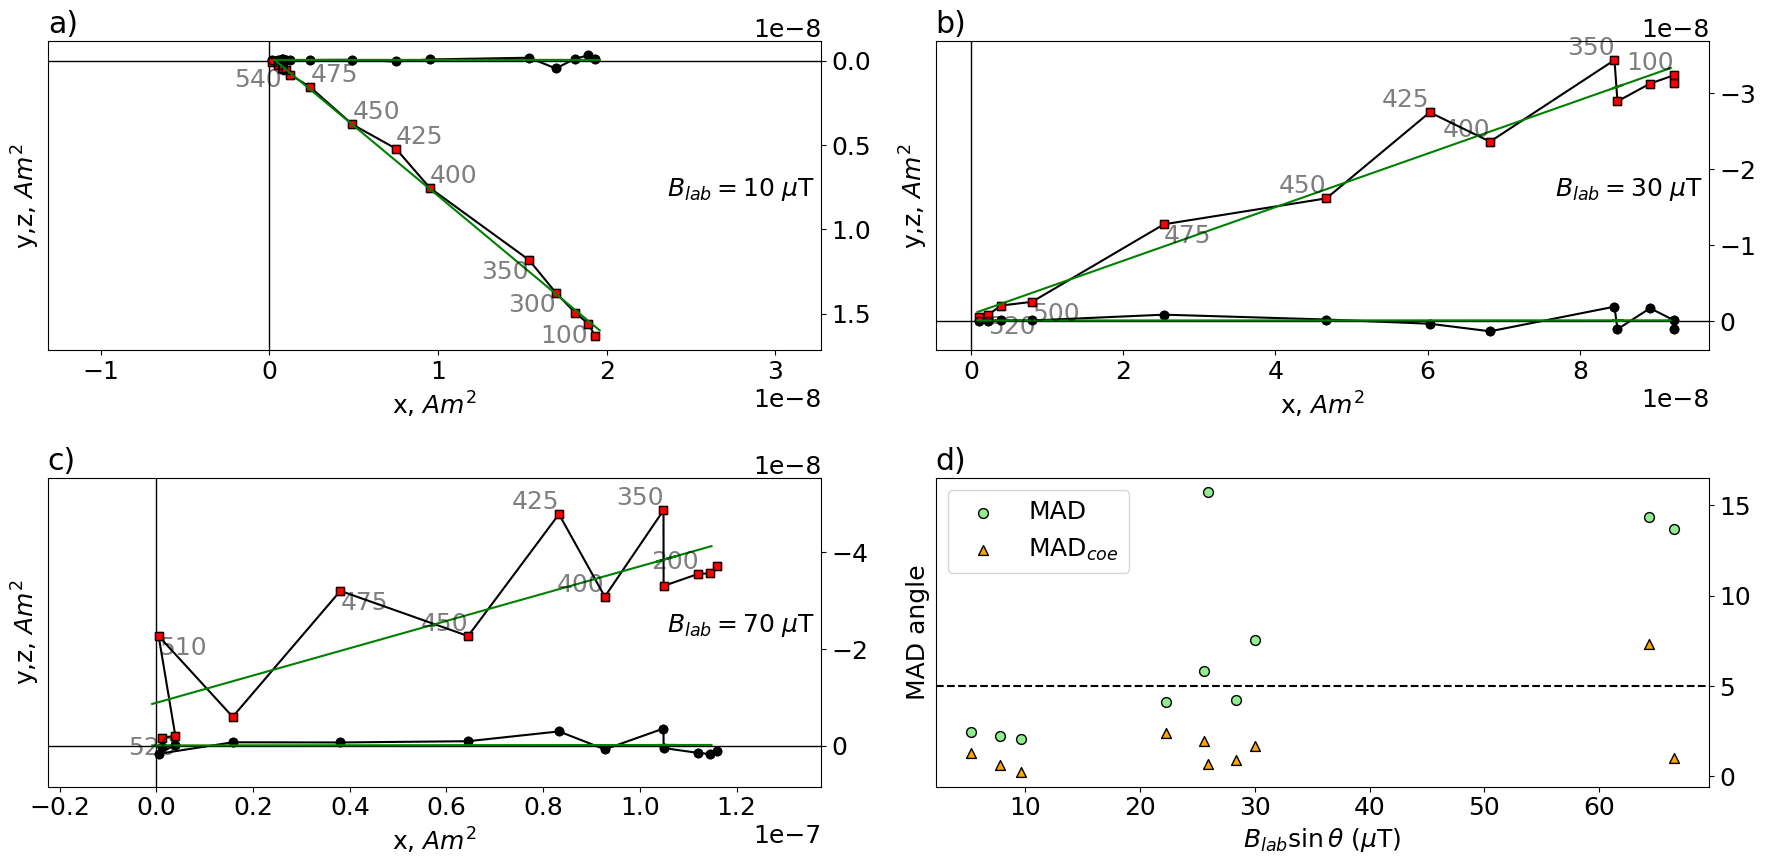

In [16]:
site=data['OA014']
fig,ax=plt.subplots(2,2,figsize=(18,9))
start=0
fields=[10,30,70]
#Loop through specimens
for specimen in ['OA014A11','OA014A08','OA014A12']:
    
    #Get IZZI data
    IZZI=site[specimen].IZZI.loc[:,'NRM_x':'NRM_y']
    
    #Rotate so that principal component lies along x axis
    pca=PCA(n_components=2)
    pca.fit(IZZI)
    if start==0:
        rot_matrix=pca.components_
    else:
        rot_matrix=-pca.components_
    IZZI_rot=np.transpose(rot_matrix@IZZI.values.T)
    
    #Change to rotated reference frame
    site[specimen].IZZI.loc[:,'NRM_x':'NRM_y']=IZZI_rot
    
    #Change temperatures
    site[specimen].change_temps(min(site[specimen].temps),max(site[specimen].temps))
    site[specimen].NRM_dirs=site[specimen].IZZI.loc[:,'NRM_x':'NRM_z'].values
    site[specimen].NRM_trunc_dirs=site[specimen].IZZI_trunc.loc[:,'NRM_x':'NRM_z'].values
    
    #Plot Zijderveld plot
    site[specimen].plot_zijd(ax[int(np.floor(start/2))][start%2])
    ax[int(np.floor(start/2))][start%2].annotate('$B_{lab}=$'+str(fields[start])+' $\mu$T',[0.8,0.5],xycoords='axes fraction')
    start+=1
    

    


#Make final part of figure

#We will collect MADs, MAD_coes, B_labs etc in here
B_lab_sinangle=[]
MADs=[]
MAD_coes=[]

#Loop through specimens
for spec in data['OA014'].specimens:
    specimen=data['OA014'][spec]
    
    #Get IZZI data
    IZZI=specimen.IZZI
    
    #Do analyses from 400C upwards (get rid of any secondary component)
    IZZI_trunc=IZZI[IZZI.temp_step>=400+273]
    ZI=IZZI_trunc[IZZI_trunc.steptype=='ZI']
    
    #Fit a PCA
    pca=PCA(n_components=3)
    pca.fit(ZI.loc[:,'NRM_x':'NRM_z'])
    
    #Get angle between Lab field and PCA principal component
    angle=np.arccos(np.abs(np.dot(pca.components_[0],[0,0,-1])))
    sinangle=np.sin(angle)
    
    #Get MAD and MAD Coe
    pca2=PCA(n_components=3)
    MAD=BiCEP.get_mad(IZZI_trunc,pca2)
    MAD_coe=BiCEP.get_mad(ZI,pca2)
    
    #Scale B_lab by sin of angle.
    B_lab_sinangle.append(specimen.B_lab*sinangle)
    
    #Append MADs to lists
    MADs.append(MAD)
    MAD_coes.append(MAD_coe)




#Scatter MADs, MAD Coes
ax[1,1].scatter(B_lab_sinangle,MADs,label='MAD',edgecolor='k',facecolor='lightgreen',s=50)
ax[1,1].scatter(B_lab_sinangle,MAD_coes,edgecolor='k',facecolor='orange',marker='^',label='MAD$_{coe}$',s=50)

#Set xlabels etc.
ax[1,1].set_xlabel(r'$B_{lab} \sin \theta $ ($\mu$T)');
ax[1,1].set_ylabel('MAD angle');
ax[1,1].axhline(5,color='k',linestyle='--')
ax[1,1].legend()
ax[0,0].set_title('a)', loc='left')
ax[0,1].set_title('b)', loc='left')
ax[1,0].set_title('c)', loc='left')
ax[1,1].set_title('d)', loc='left')
for a in ax:
    for b in a:
        b.yaxis.tick_right()
    
#Save figure
plt.tight_layout()
plt.savefig('Figures/Lab_Field_Dependence.pdf')

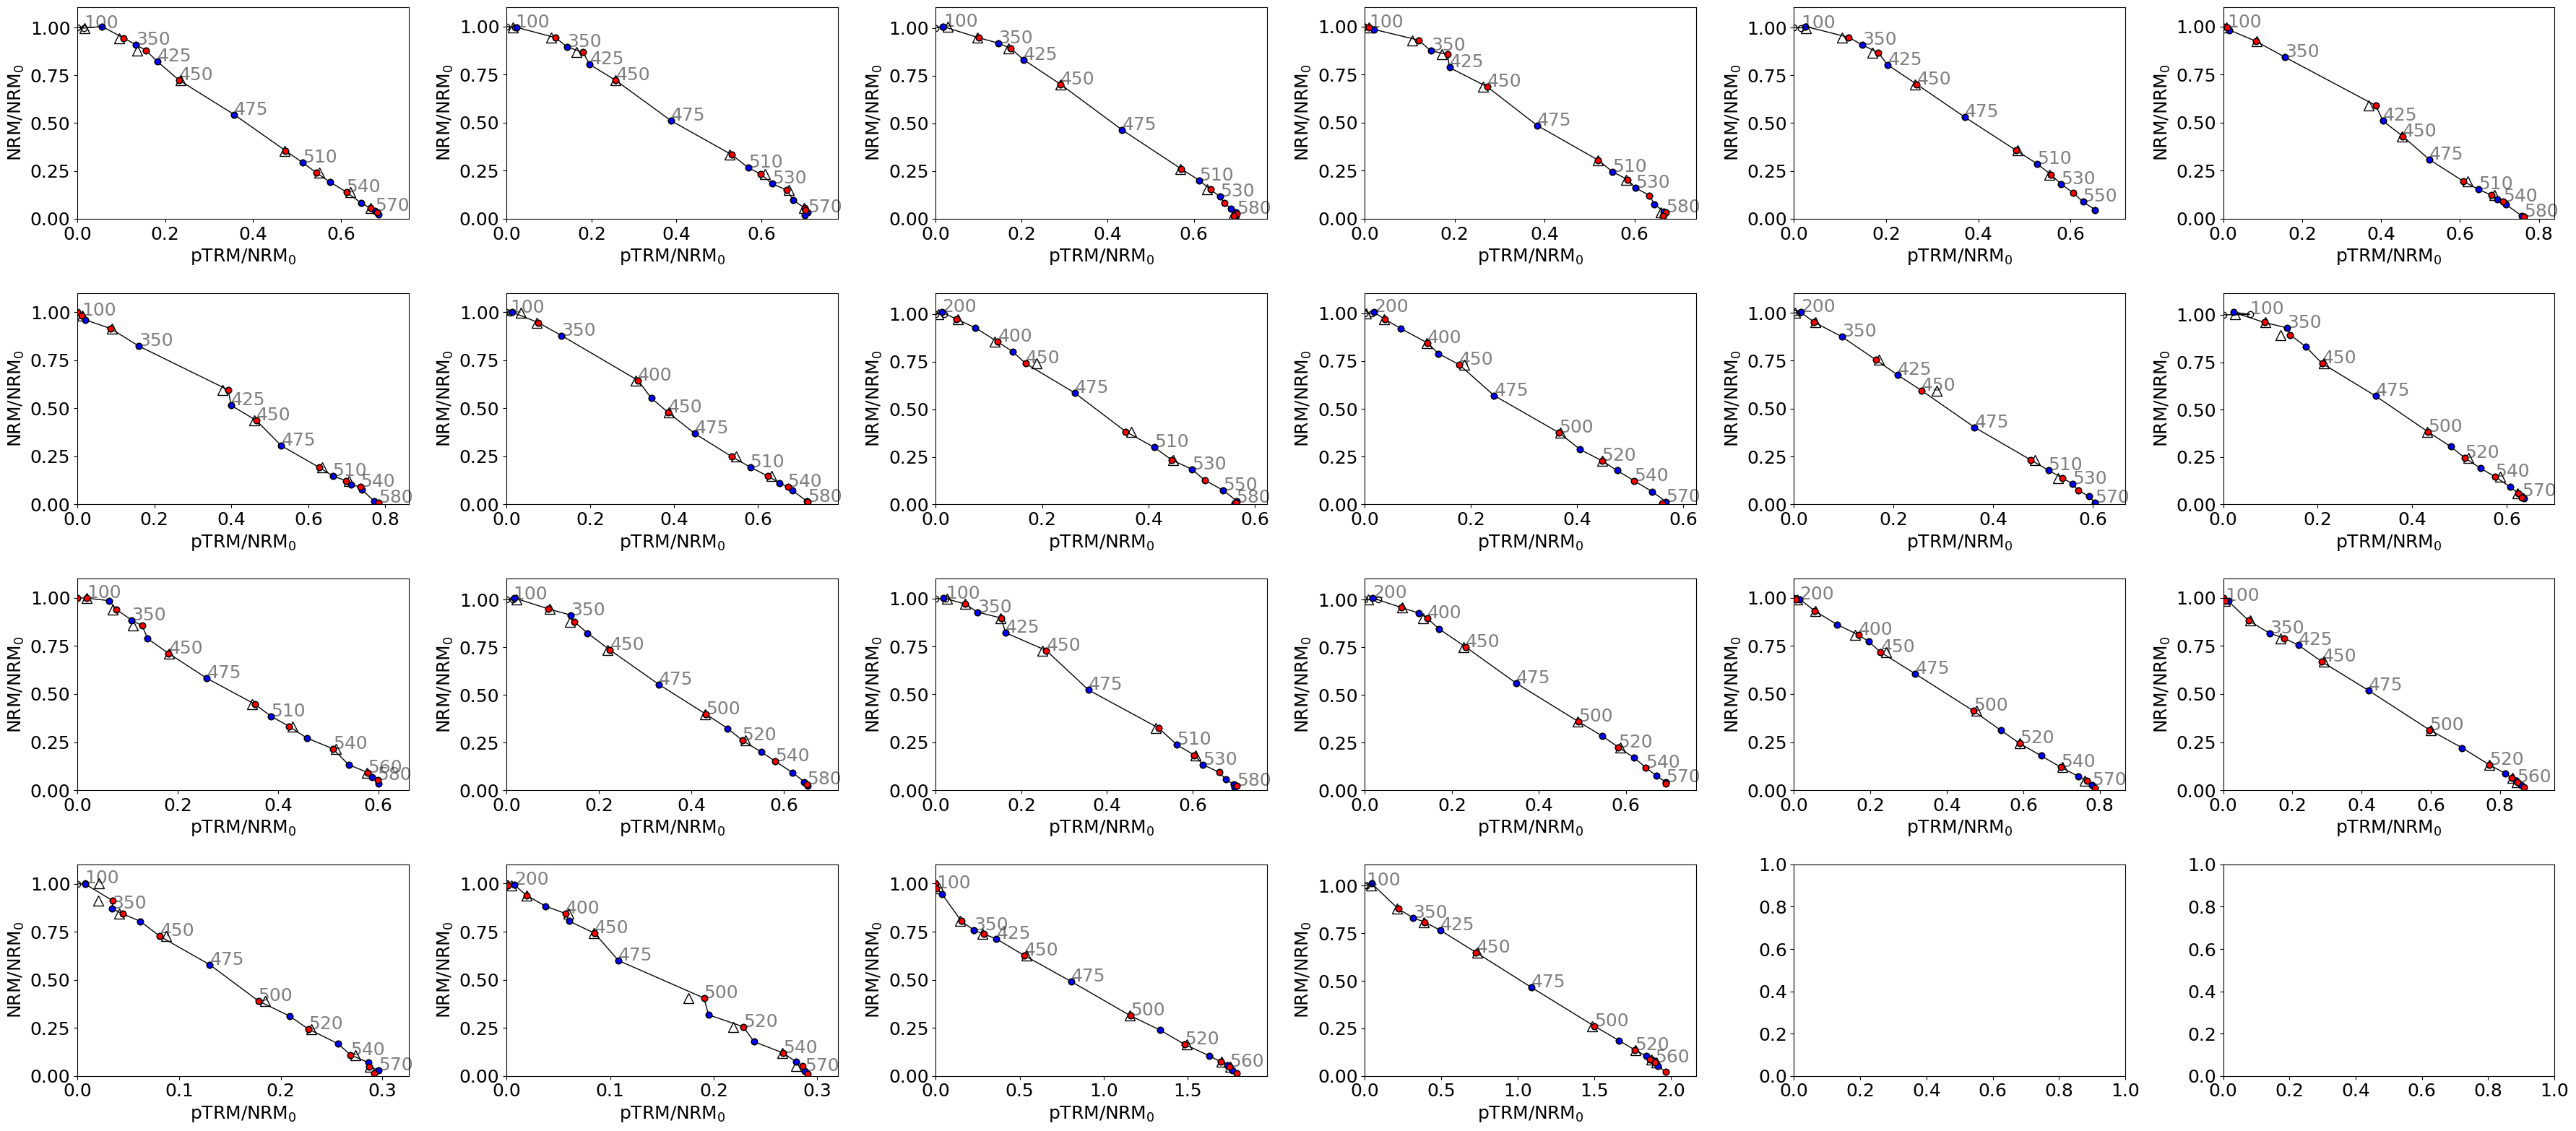

In [17]:
fig,ax=plt.subplots(4,6,figsize=(36,16))
j=0
k=0
for specimen in data['OA030'].specimens.values():
    if j==6:
        j=0
        k+=1
    specimen.plot_arai(ax[k][j])
    j+=1
for specimen in data['MU012'].specimens.values():
    if j==6:
        j=0
        k+=1
    specimen.plot_arai(ax[k][j])
    j+=1
plt.tight_layout();
plt.savefig('texture_arais.pdf')

dict_values([Specimen OA030A01in site OA030, Specimen OA030A02in site OA030, Specimen OA030A03in site OA030, Specimen OA030A04in site OA030, Specimen OA030A05in site OA030, Specimen OA030B01in site OA030, Specimen OA030B02in site OA030, Specimen OA030B03in site OA030, Specimen OA030C01in site OA030, Specimen OA030C02in site OA030, Specimen OA030C03in site OA030, Specimen OA030D01in site OA030, Specimen OA030D02in site OA030, Specimen OA030D03in site OA030, Specimen OA030D04in site OA030, Specimen OA030D05in site OA030])